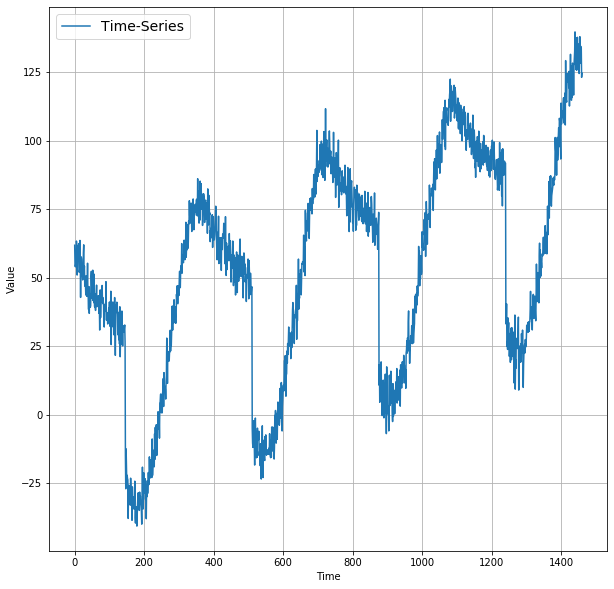

In [18]:
"""
In this nb, we are forecasting Time-Series with a Simple Machine Learning Model and then with a bit more
complex model.
"""

# Importing stuff
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.compat.v2 as tf
keras = tf.keras

# A function to plot time-series. This will be called finally when complete series is built
def plot_series(time,series,format="-",start=0,end=None,label=None):
    plt.plot(time[start:end],series[start:end],format,label=label)
    plt.xlabel('Time')
    plt.ylabel('Value')
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
# Function to create a trend
def trend(time,slope=0):
    return slope*time

# Creating a time series
time = np.arange(4*365+1)
baseline = 10 #Base value for trend 
# series = baseline + trend(time,0.1)

# Function which creates a random pattern. This pattern will be repeated to get a seasonal pattern
def seasonal_pattern(seasonal_time):
    return np.where(seasonal_time < 0.4,
                    1/np.exp(3*seasonal_time),
                    np.cos(seasonal_time*2*np.pi))

# Function to repeat seasonal pattern
def seasonality(time,period,amplitude=1,phase=0):
    season_time = ((time+phase) % period)/period
    return amplitude * seasonal_pattern(season_time)

# Function to create white noise. seed parameter here is used by random number generator as a base to create
# random number. When it is None, rnd will use system time as seed. But, if we give some constant value like 42,
# then every time same noise will be generated. Thus, to get different noise everytime keep seed as None even 
# while calling the function
def white_noise(time,noise_level=1,seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

# Creating Seasonality 
amplitude = 50
series = seasonality(time,period=365,amplitude=amplitude) + baseline

# Creating White Noise
noise_level = 5
noise = white_noise(time,noise_level)

# Creating seasonality with trend
slope = 0.05
series = baseline + trend(time,slope) + seasonality(time,period=365,amplitude=amplitude)

# Finally plotting complete time-series
series += noise
plt.figure(figsize=(10,10))
plot_series(time,series,label="Time-Series")

# Creating Training and Validation data
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [19]:
def window_dataset(series,window_size,batch_size=32,shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size+1,shift=1,drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1],window[-1:]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [20]:
# Building the model
tf.random.set_seed(42)
np.random.seed(42)

window_size=30
train_set = window_dataset(x_train,window_size)
valid_set = window_dataset(x_valid,window_size)

model = tf.keras.Sequential([
    keras.layers.Dense(1,input_shape = [window_size])
])

# We can use Learning Rate Scheduler which can show us at which lr model is giving better results
# After every 30 epochs lr is * by 10 power and model is evaluated using it
lr_schedule = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-6 * 10 ** (epoch/30))

# Optimizer is Stochastic Gradient Descent
optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
             optimizer=optimizer,
             metrics=['mae'])

history = model.fit(train_set,epochs=100,validation_data=valid_set,callbacks=[lr_schedule])


Epoch 1/100
31/31 [==============================] - 1s 30ms/step - loss: 86.3776 - mae: 87.3047 - val_loss: 0.0000e+00 - val_mae: 0.0000e+00
Epoch 2/100
31/31 [==============================] - 0s 11ms/step - loss: 71.7101 - mae: 70.4755 - val_loss: 111.7984 - val_mae: 112.0890
Epoch 3/100
31/31 [==============================] - 0s 11ms/step - loss: 53.3167 - mae: 51.5377 - val_loss: 74.0354 - val_mae: 74.4703
Epoch 4/100
31/31 [==============================] - 0s 12ms/step - loss: 33.5316 - mae: 32.1831 - val_loss: 37.1647 - val_mae: 37.7255
Epoch 5/100
31/31 [==============================] - 0s 11ms/step - loss: 15.8806 - mae: 14.9294 - val_loss: 9.8634 - val_mae: 10.3610
Epoch 6/100
31/31 [==============================] - 0s 11ms/step - loss: 10.1500 - mae: 10.5078 - val_loss: 9.5880 - val_mae: 10.2544
Epoch 7/100
31/31 [==============================] - 0s 11ms/step - loss: 9.6444 - mae: 10.3439 - val_loss: 9.9687 - val_mae: 10.3931
Epoch 8/100
31/31 [=========================

31/31 [==============================] - 0s 14ms/step - loss: 5.9059 - mae: 6.2325 - val_loss: 5.8257 - val_mae: 6.3166
Epoch 63/100
31/31 [==============================] - 0s 11ms/step - loss: 4.9951 - mae: 5.7849 - val_loss: 9.1664 - val_mae: 9.6042
Epoch 64/100
31/31 [==============================] - 0s 14ms/step - loss: 5.4841 - mae: 5.6684 - val_loss: 8.9330 - val_mae: 9.4684
Epoch 65/100
31/31 [==============================] - 0s 10ms/step - loss: 7.0882 - mae: 6.8599 - val_loss: 4.6701 - val_mae: 5.1034
Epoch 66/100
31/31 [==============================] - 0s 12ms/step - loss: 4.6806 - mae: 5.2260 - val_loss: 8.1965 - val_mae: 8.7698
Epoch 67/100
31/31 [==============================] - 0s 14ms/step - loss: 5.2974 - mae: 5.5857 - val_loss: 5.5292 - val_mae: 6.0667
Epoch 68/100
31/31 [==============================] - 0s 13ms/step - loss: 5.2370 - mae: 6.0220 - val_loss: 18.2159 - val_mae: 18.9154
Epoch 69/100
31/31 [==============================] - 0s 12ms/step - loss: 7.966

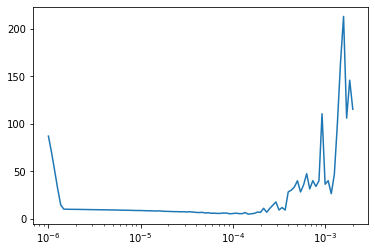

In [21]:
# Optimum value is 1e-5
plt.semilogx(history.history['lr'],history.history['loss'])

In [22]:
# Building the model
tf.random.set_seed(42)
np.random.seed(42)

window_size=30
train_set = window_dataset(x_train,window_size)
valid_set = window_dataset(x_valid,window_size)

model = tf.keras.Sequential([
    keras.layers.Dense(1,input_shape = [window_size])
])

# Optimizer is Stochastic Gradient Descent
optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
             optimizer=optimizer,
             metrics=['mae'])

# EarlyStopping is used to avoid Overfitting. If best value of metric on validation set doesn't change for
# 10 epochs, Training is terminated. We can use more epochs if needed with this.
early_stopper = keras.callbacks.EarlyStopping(patience=10)

history = model.fit(train_set,epochs=100,validation_data=valid_set,callbacks=[early_stopper])

# MAE of almost 5.04 :)

Epoch 1/100
31/31 [==============================] - 1s 38ms/step - loss: 48.8130 - mae: 50.0117 - val_loss: 0.0000e+00 - val_mae: 0.0000e+00
Epoch 2/100
31/31 [==============================] - 0s 11ms/step - loss: 14.1529 - mae: 13.5369 - val_loss: 10.4452 - val_mae: 11.0923
Epoch 3/100
31/31 [==============================] - 1s 25ms/step - loss: 9.9051 - mae: 10.2018 - val_loss: 9.6034 - val_mae: 9.9706
Epoch 4/100
31/31 [==============================] - 0s 12ms/step - loss: 9.6354 - mae: 10.0011 - val_loss: 9.1853 - val_mae: 9.7692
Epoch 5/100
31/31 [==============================] - 1s 18ms/step - loss: 8.8419 - mae: 9.7410 - val_loss: 9.0854 - val_mae: 9.5491
Epoch 6/100
31/31 [==============================] - 0s 15ms/step - loss: 9.3742 - mae: 9.6713 - val_loss: 8.9906 - val_mae: 9.6496
Epoch 7/100
31/31 [==============================] - 0s 11ms/step - loss: 8.8632 - mae: 9.5004 - val_loss: 8.9464 - val_mae: 9.3438
Epoch 8/100
31/31 [==============================] - 0s 11ms

31/31 [==============================] - 0s 15ms/step - loss: 5.8966 - mae: 6.3121 - val_loss: 5.9108 - val_mae: 6.4345
Epoch 63/100
31/31 [==============================] - 0s 13ms/step - loss: 5.7928 - mae: 6.4100 - val_loss: 5.8237 - val_mae: 6.2701
Epoch 64/100
31/31 [==============================] - 0s 11ms/step - loss: 5.7068 - mae: 6.1891 - val_loss: 5.6951 - val_mae: 6.2443
Epoch 65/100
31/31 [==============================] - 0s 13ms/step - loss: 5.7445 - mae: 6.1879 - val_loss: 6.1567 - val_mae: 6.5693
Epoch 66/100
31/31 [==============================] - 0s 12ms/step - loss: 5.7082 - mae: 6.2024 - val_loss: 5.7146 - val_mae: 6.2058
Epoch 67/100
31/31 [==============================] - 0s 13ms/step - loss: 5.7234 - mae: 6.1040 - val_loss: 5.7520 - val_mae: 6.1645
Epoch 68/100
31/31 [==============================] - 0s 12ms/step - loss: 5.7121 - mae: 6.0689 - val_loss: 5.6592 - val_mae: 6.1484
Epoch 69/100
31/31 [==============================] - 0s 13ms/step - loss: 5.7293 

In [23]:
# Function to apply our model to series(This will be validation series)
def model_forecast(model,series,window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [24]:
lin_forecast = model_forecast(model,series[split_time-window_size:-1],window_size)[:, 0]

In [25]:
lin_forecast.shape

(461,)

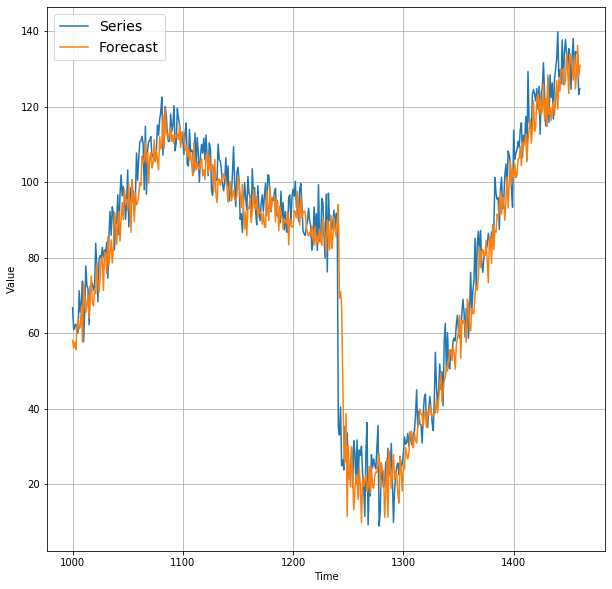

In [26]:
plt.figure(figsize=(10,10))
plot_series(time_valid,x_valid,label="Series")
plot_series(time_valid,lin_forecast,label="Forecast")

In [27]:
keras.metrics.mean_absolute_error(lin_forecast,x_valid).numpy()

5.828720942941999

Epoch 1/100
31/31 [==============================] - 2s 48ms/step - loss: 43.3601 - mae: 43.9943 - val_loss: 0.0000e+00 - val_mae: 0.0000e+00
Epoch 2/100
31/31 [==============================] - 1s 17ms/step - loss: 42.6484 - mae: 43.2510 - val_loss: 71.7696 - val_mae: 72.1610
Epoch 3/100
31/31 [==============================] - 0s 11ms/step - loss: 41.7819 - mae: 42.3606 - val_loss: 69.5521 - val_mae: 70.0399
Epoch 4/100
31/31 [==============================] - 1s 17ms/step - loss: 40.4372 - mae: 41.3516 - val_loss: 67.3118 - val_mae: 67.7179
Epoch 5/100
31/31 [==============================] - 0s 13ms/step - loss: 40.3081 - mae: 40.2253 - val_loss: 64.9436 - val_mae: 65.0701
Epoch 6/100
31/31 [==============================] - 1s 19ms/step - loss: 38.8321 - mae: 38.9380 - val_loss: 61.9266 - val_mae: 62.1549
Epoch 7/100
31/31 [==============================] - 0s 12ms/step - loss: 36.7880 - mae: 37.5058 - val_loss: 58.3240 - val_mae: 58.8473
Epoch 8/100
31/31 [=======================

Epoch 62/100
31/31 [==============================] - 0s 13ms/step - loss: 4.9522 - mae: 5.4028 - val_loss: 5.9122 - val_mae: 6.4042
Epoch 63/100
31/31 [==============================] - 0s 14ms/step - loss: 6.0364 - mae: 6.7705 - val_loss: 10.3448 - val_mae: 10.8419
Epoch 64/100
31/31 [==============================] - 0s 11ms/step - loss: 5.2790 - mae: 5.7602 - val_loss: 5.3097 - val_mae: 5.8177
Epoch 65/100
31/31 [==============================] - 0s 14ms/step - loss: 5.1108 - mae: 5.6426 - val_loss: 4.9972 - val_mae: 5.4521
Epoch 66/100
31/31 [==============================] - 0s 12ms/step - loss: 4.6330 - mae: 5.2867 - val_loss: 8.3060 - val_mae: 8.8493
Epoch 67/100
31/31 [==============================] - 0s 13ms/step - loss: 5.5839 - mae: 5.7797 - val_loss: 5.1027 - val_mae: 5.6005
Epoch 68/100
31/31 [==============================] - 0s 12ms/step - loss: 4.7129 - mae: 5.1746 - val_loss: 4.8333 - val_mae: 5.3234
Epoch 69/100
31/31 [==============================] - 0s 13ms/step 

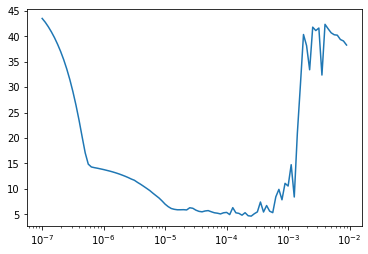

In [28]:
# Building the more complex model 
tf.random.set_seed(42)
np.random.seed(42)

window_size=30
train_set = window_dataset(x_train,window_size)
valid_set = window_dataset(x_valid,window_size)

model = tf.keras.Sequential([
    keras.layers.Dense(10,activation='relu',input_shape = [window_size]),
    keras.layers.Dense(10,activation='relu'),
    keras.layers.Dense(1)
])

# We can use Learning Rate Scheduler which can show us at which lr model is giving better results
# After every 20 epochs lr is * by 10 power and model is evaluated using it
lr_schedule = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-7 * 10 ** (epoch/20))

# Optimizer is Stochastic Gradient Descent
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
             optimizer=optimizer,
             metrics=['mae'])

history = model.fit(train_set,epochs=100,validation_data=valid_set,callbacks=[lr_schedule])

# Optimum value is 1e-5 again
plt.semilogx(history.history['lr'],history.history['loss'])

In [29]:
# Building the more complex model 
tf.random.set_seed(42)
np.random.seed(42)

window_size=30
train_set = window_dataset(x_train,window_size)
valid_set = window_dataset(x_valid,window_size)

model = tf.keras.Sequential([
    keras.layers.Dense(10,activation='relu',input_shape = [window_size]),
    keras.layers.Dense(10,activation='relu'),
    keras.layers.Dense(1)
])

# Optimizer is Stochastic Gradient Descent
optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
             optimizer=optimizer,
             metrics=['mae'])

early_stopper = keras.callbacks.EarlyStopping(patience=10)
history = model.fit(train_set,epochs=100,validation_data=valid_set,callbacks=[early_stopper])


Epoch 1/100
31/31 [==============================] - 1s 45ms/step - loss: 27.0326 - mae: 27.6642 - val_loss: 0.0000e+00 - val_mae: 0.0000e+00
Epoch 2/100
31/31 [==============================] - 0s 12ms/step - loss: 14.5741 - mae: 14.5002 - val_loss: 8.3096 - val_mae: 8.9048
Epoch 3/100
31/31 [==============================] - 0s 12ms/step - loss: 12.4243 - mae: 12.8180 - val_loss: 7.7997 - val_mae: 8.2482
Epoch 4/100
31/31 [==============================] - 0s 15ms/step - loss: 11.6351 - mae: 11.8549 - val_loss: 7.3108 - val_mae: 7.7939
Epoch 5/100
31/31 [==============================] - 1s 23ms/step - loss: 10.2831 - mae: 10.7842 - val_loss: 8.0777 - val_mae: 8.5148
Epoch 6/100
31/31 [==============================] - 0s 14ms/step - loss: 9.8379 - mae: 9.9248 - val_loss: 6.7052 - val_mae: 7.2281
Epoch 7/100
31/31 [==============================] - 0s 14ms/step - loss: 8.5743 - mae: 9.1193 - val_loss: 6.4110 - val_mae: 6.8656
Epoch 8/100
31/31 [==============================] - 0s 12

In [30]:
dense_forecast = model_forecast(model,series[split_time-window_size:-1],window_size)[:,0]

5.7929173

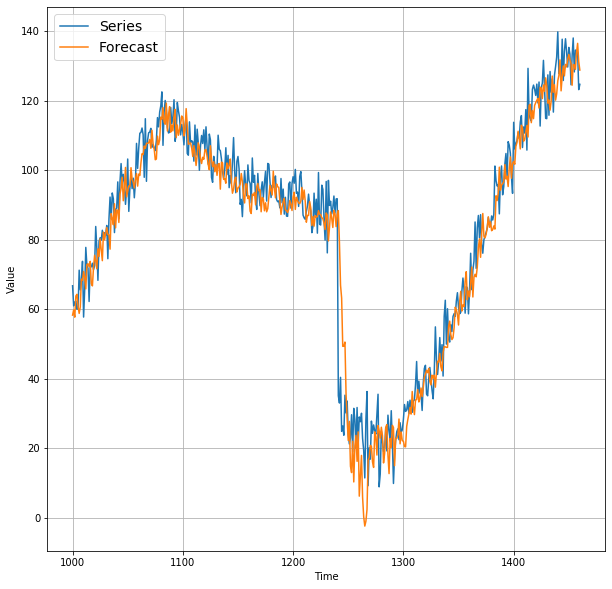

In [31]:
plt.figure(figsize=(10,10))
plot_series(time_valid,x_valid,label="Series")
plot_series(time_valid,dense_forecast,label="Forecast")
keras.metrics.mean_absolute_error(x_valid,dense_forecast).numpy()